# The Bayesian Bootstrap

*A short guide to a simple and powerful alternative to the bootstrap*

In causal inference we do not want just to compute treatment effect, we also want to do **inference** (duh!). In some cases, it's very easy to compute the asymptotic difference of an estimator, thanks to the [**central limit theorem**](https://en.wikipedia.org/wiki/Central_limit_theorem). This is the case of computing the average treatment effect in AB tests or randomized controlled trials, for example. However, in other settings, inference is more **complicated**. The most frequent setting is the computation of quantities that are not sums or averages, such as the median treatment effect, for example. In these cases, we cannot rely on the central limit theorem. What can we do then? 

The **bootstrap** is the answer! It is a very powerful procedure to compute the distribution of an estimator, without needing any knowledge of the data generating process. It is also very **intuitive and simple** to implement: just re-sample your data with replacement a lot of times and compute your estimator on the re-computed sample.

Can we do better? The answer is yes! The **Bayesian Bootstrap** is a powerful procedure that in a lot of setting performs **better** than the bootstrap. In particular, it's usually faster, can give tighter confidence intervals and prevents a lot of corner cases of the bootstrap. In this article we are going to explore this simple but powerful procedure more in detail.

## The Bootstrap

Bootstrap is a procedure to compute properties of an estimator by random **re-sampling with replacement** from the data. It was first introduced by [Efron (1979)](https://www.jstor.org/stable/2958830). The procedure is very simple and consists in the following steps.

Suppose you have access to an i.i.d. sample $\lbrace X_i \rbrace_{i=1}^n$ and you want to compute a statistic $\theta$ using an estimator $\hat \theta(X)$. You can approximate the distribution of $\hat \theta$ by

1. Sample $n$ observations with replacement from your sample $\lbrace \tilde X_i \rbrace_{i=1}^n$
2. Compute the estimator $\hat \theta_{bootstrap}(\tilde X)$
3. Repeat steps 1 and 2 a large number of times 

The distribution of $\hat \theta_{bootstrap}$ is a good approximation of the distribution of $\hat \theta$.

**Why is the bootstrap so powerful?**

First of all, it's **easy to implement**. It does not require you to do anything more than what you were already doing: estimating $\theta$. You just need to do it *a lot of times*. Indeed, the main disadvantage of the bootstrap is its **computational speed**. If estimating $\theta$ once is slow, bootstrapping it is prohibitive.

Second, the bootstrap makes **no distributional assumption**. It only assumes a representative sample from your population, where observations are independent from each other. This assumption might be violated when observations are tightly connected with each other, such when studying social networks.

**Is bootstrap just weighting?**

In the end, what we are doing is assigning **integer weights** to our observations, such that their sum adds up to $n$. Such distribution is the [**multinomial distribution**](https://en.wikipedia.org/wiki/Multinomial_distribution).

Let's have a look at what a multinomial distribution look like by drawing a sample of size 10.000.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *

In [3]:
N = 10_000
np.random.seed(1)
bootstrap_weights = np.random.multinomial(N, np.ones(N)/N)
np.sum(bootstrap_weights)

10000

First of all, we check that indeed the weights sum up to 1000, or equivalently, we generated a re-sample of the same size of the data.

We can now plot the **distribution of weights**.

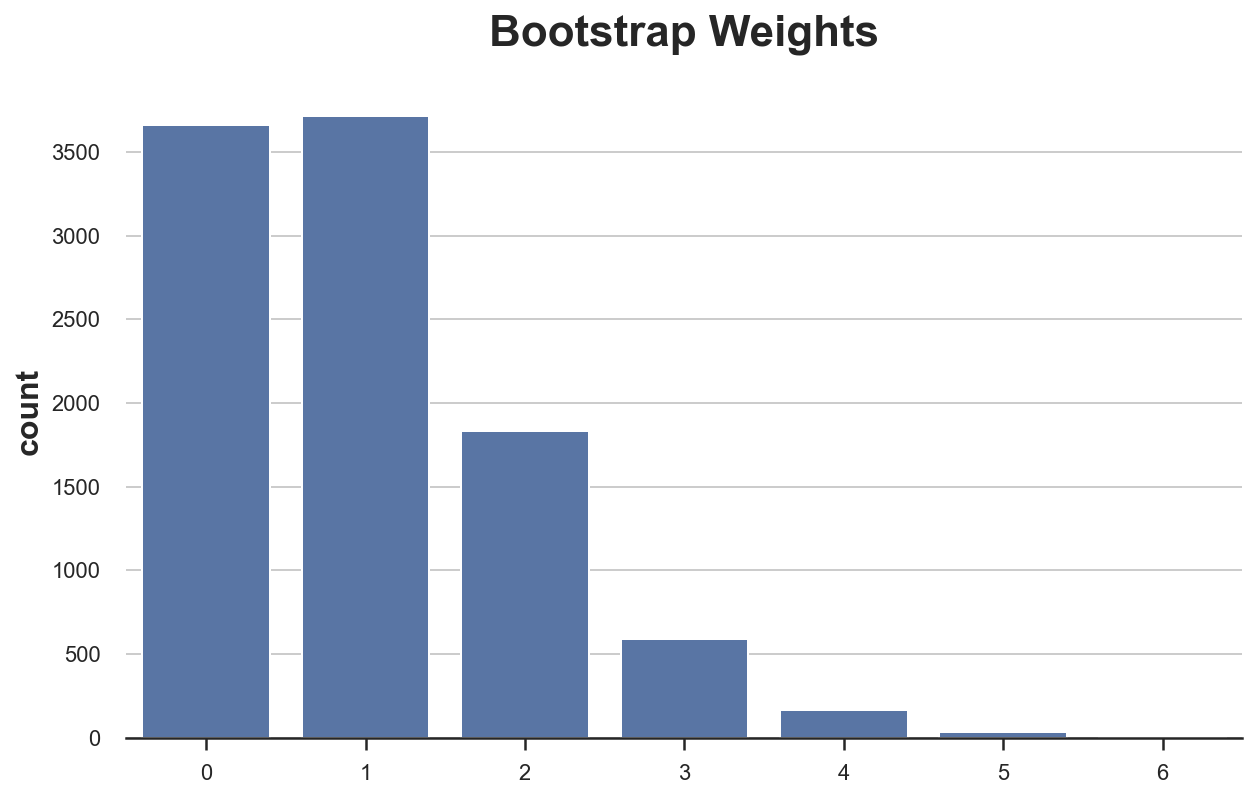

In [4]:
sns.countplot(bootstrap_weights, color='C0').set(title='Bootstrap Weights');

As we can see, around 3600 observations got zero weight, however a couple of observations got a weights of 6. Or equivalently, around 3600 observations did not get re-sampled while a couple of observations got samples as many as 6 times.

Now you might have a spontaneous question: why not use **continuous weights** instead of discrete ones?

Very good question! The **Bayesian Bootstrap** is the answer.

## The Bayesian Bootstrap

The Bayesian bootstrap was introduced by [Rubin (1981)](https://www.jstor.org/stable/2240875) and it's based on a very simple **idea**: why not draw a smoother distribution of weights? The continuous equivalent of the multinomial distribution is the [**Dirichelet distribution**](https://en.wikipedia.org/wiki/Dirichlet_distribution).

The Bayesian Bootstrap has **many advantages**. 

The first and most intuitive one is that it delivers estimates that are much more **smooth** than the normal bootstrap, because of its continuous weighting scheme.

Moreover, the continuous weighting scheme **prevents corner cases** from emerging, since no observation will ever receive zero weight. For example, in linear regression, no problem of [collinearity](https://en.wikipedia.org/wiki/Multicollinearity) emerges, if there wasn't one in the original sample.

Lastly, being a Bayesian method, we gain **interpretation**: the estimated distribution of the estimator can be interpreted as the [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) with an [uninformative prior](https://en.wikipedia.org/wiki/Prior_probability).

Let's repeat the sample experiment as before, but with the Dirichelet distribution.

In [5]:
bayesian_weights = np.random.dirichlet(alpha=np.ones(N), size=1)[0] * N
np.sum(bayesian_weights)

10000.000000000005

The weights naturally sum to (approximately) 1, so we have to scale them by a factor N.

As before, we can plot the distribution of weights, with the difference that now we have continuous weights, so we have to approximate the distribution. We can do so by 

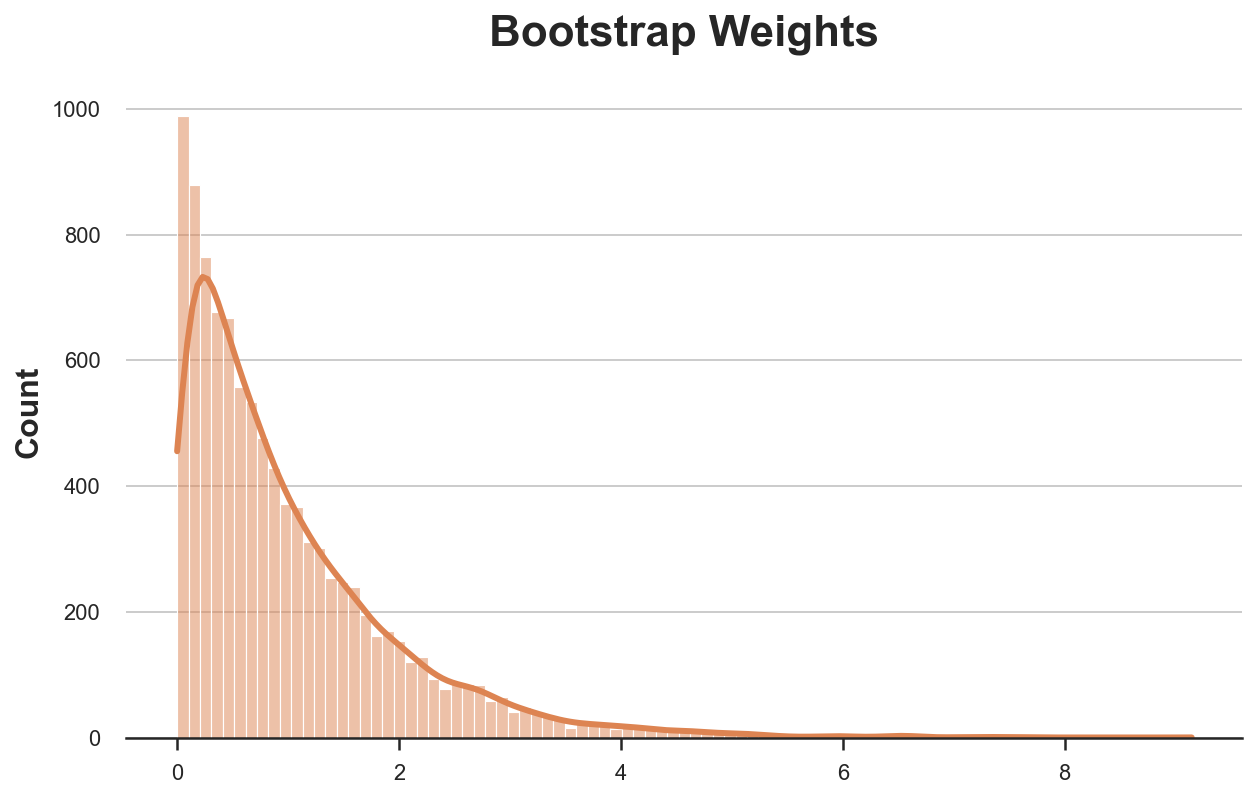

In [6]:
sns.histplot(bayesian_weights, color='C1', kde=True).set(title='Bootstrap Weights');

As you might have noticed, the Dirichelet distirbution has a parameter $\alpha$ that we have set to 1 for all observations. What does it do?

The $\alpha$ parameter essentially governs both the absolute and relative probability of being samples. Increasing $\alpha$ for all observations makes the distribution less skewed so that all observations have a more similar weight. For $\alpha \to \infty$, all observations receiver the same weight and we are back to the original sample. 

How should we pick $\alpha$? [Shao and Tu (1995)](https://link.springer.com/book/10.1007/978-1-4612-0795-5) suggest the following.

> *The distribution of the random weight vector does not have to be restricted to the Diri(l, ... , 1). Later investigations found that the weights having a scaled Diri(4, ... ,4) distribution give better approximations (Tu and Zheng, 1987)*

Let's have a look at how a Dirichelet distribution with $\alpha = 4$ for all observations compare to our previous distribution with $\alpha = 1$ for all observations.

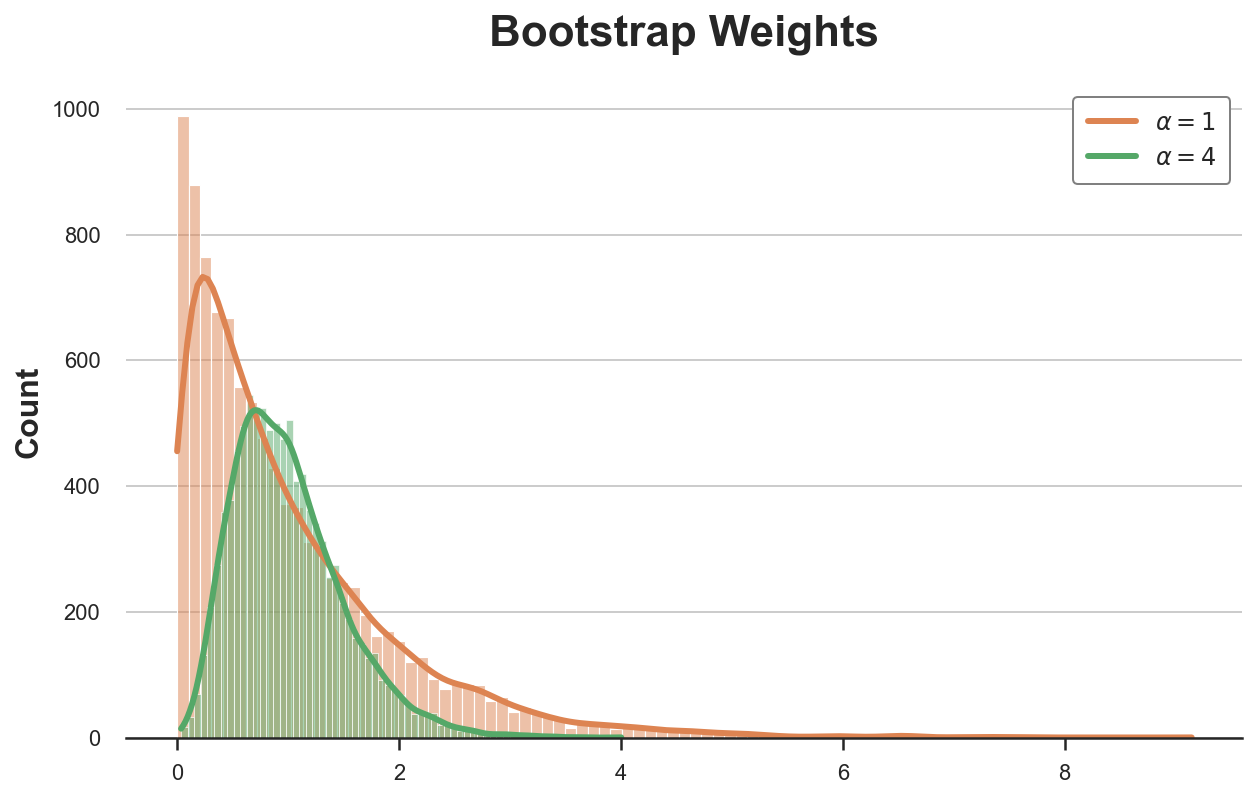

In [7]:
bayesian_weights2 = np.random.dirichlet(np.ones(N) * 4, 1)[0] * N
sns.histplot(bayesian_weights, color='C1', kde=True)
sns.histplot(bayesian_weights2, color='C2', kde=True).set(title='Bootstrap Weights');
plt.legend([r'$\alpha = 1$', r'$\alpha = 4$']);

The new distribution is much less skewed and more concentrated around the average value of 1.

## Examples

Let's have a look at a couple of examples, where we compare both inference procedures.

### Mean of a Skewed Distribution

First, let's have a look at one of the simplest and most common estimators: the **sample mean**. 

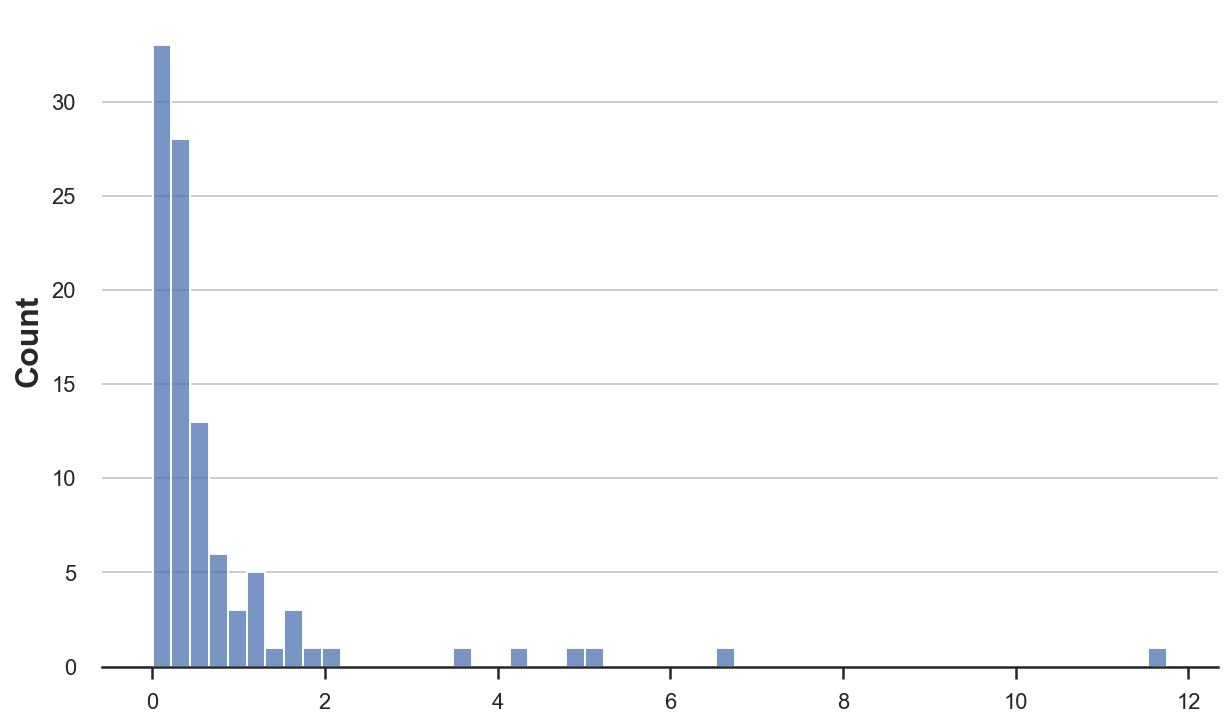

In [199]:
np.random.seed(2)
X = pd.Series(np.random.pareto(2, 100))
sns.histplot(X);

In [200]:
def classic_boot(df, estimator, seed=1):
    df_boot = df.sample(n=len(df), replace=True, random_state=seed)
    estimate = estimator(df_boot)
    return estimate

In [201]:
classic_boot(X, np.mean)

0.7079805545831946

In [202]:
def bayes_boot(df, estimator, seed=1):
    np.random.seed(seed)
    w = np.random.dirichlet(np.ones(len(df)), 1)[0]
    result = estimator(df, weights=w)
    return result

In [203]:
bayes_boot(X, np.average)

1.0378495251293498

In [204]:
from joblib import Parallel, delayed

def bootstrap(boot_method, df, estimator, K):
    r = Parallel(n_jobs=8)(delayed(boot_method)(df, estimator, seed=i) for i in range(K))
    return r

In [205]:
def compare_boot(df, boot1, boot2, estimator, K):
    s1 = bootstrap(boot1, df, estimator, K)
    s2 = bootstrap(boot2, df, estimator, K)
    df = pd.DataFrame({'Estimate': s1 + s2,
                       'Estimator': ['Classic']*K + ['Bayes']*K})
    sns.histplot(data=df, x='Estimate', hue='Estimator')
    plt.legend([f'Bayes:   {np.mean(s2):.2f} ({np.std(s2):.2f})',
                f'Classic: {np.mean(s1):.2f} ({np.std(s1):.2f})'])
    plt.title('Comparing Bootstrap Methods')

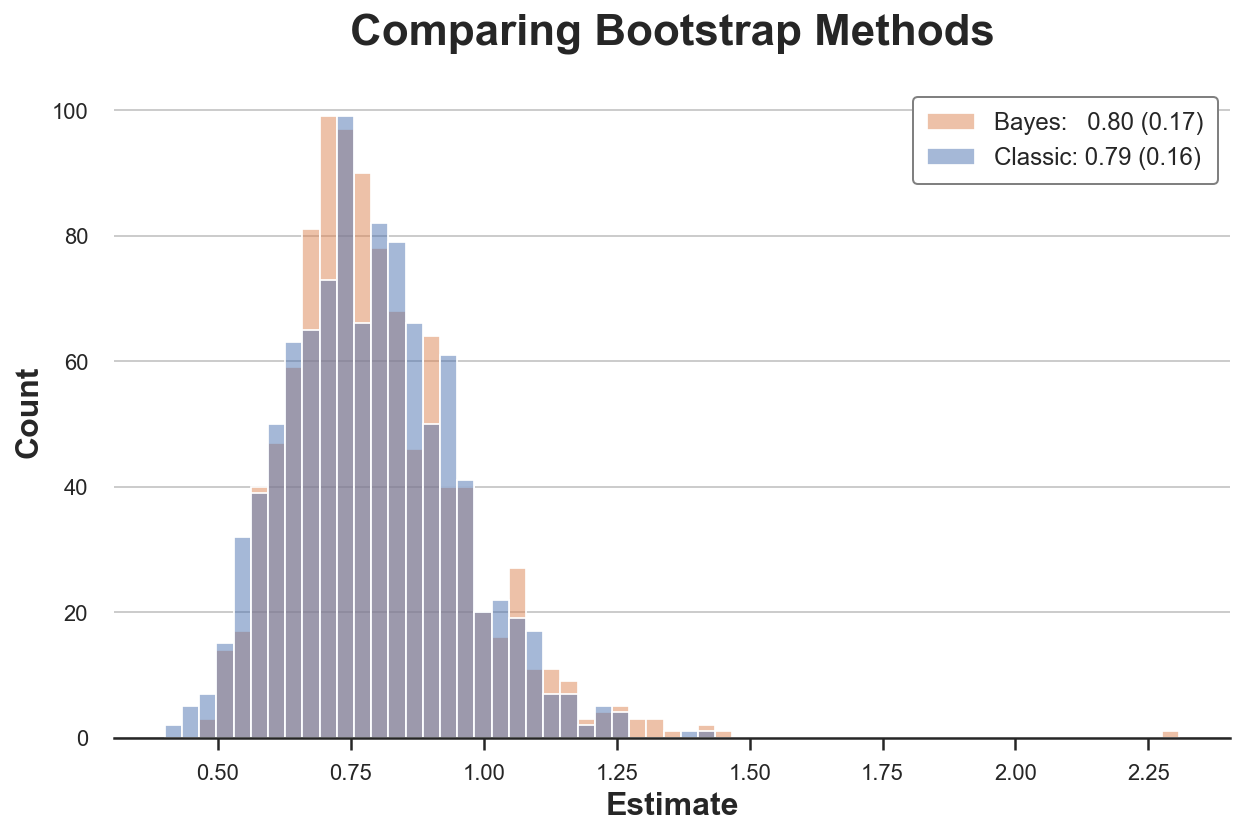

In [206]:
compare_boot(X, classic_boot, bayes_boot, np.average, 1000)

In this setting, both procedures give a very similar answer. 

Which one is faster?

In [207]:
import time

def compare_time(df, boot1, boot2, estimator, K):
    t1, t2 = np.zeros(K), np.zeros(K)
    for k in range(K):
        
        # Classic bootstrap
        start = time.time()
        boot1(df, estimator)
        t1[k] = time.time() - start
    
        # Bayesian bootstrap
        start = time.time()
        boot2(df, estimator)
        t2[k] = time.time() - start
    
    print(f"Bayes wins {np.mean(t1 > t2)*100}% of the time (by {np.mean((t1 - t2)/t1*100):.2f}%)")

In [208]:
compare_time(X, classic_boot, bayes_boot, np.average, 1000)

Bayes wins 100.0% of the time (by 83.43%)


The Bayesian bootstrap is faster than the classical bootstrap 100% of the simulations, and by an impressive 83%!

### No Weighting? No Problem 

What if we have an estimator that does not accept weights, such as the median? We can do **two-level sampling**.

In [209]:
def twolv_boot(df, estimator, seed=1):
    np.random.seed(seed)
    w = np.random.dirichlet(np.ones(len(df))*4, 1)[0]
    df_boot = df.sample(n=len(df)*10, replace=True, weights=w, random_state=seed)
    result = estimator(df_boot)
    return result

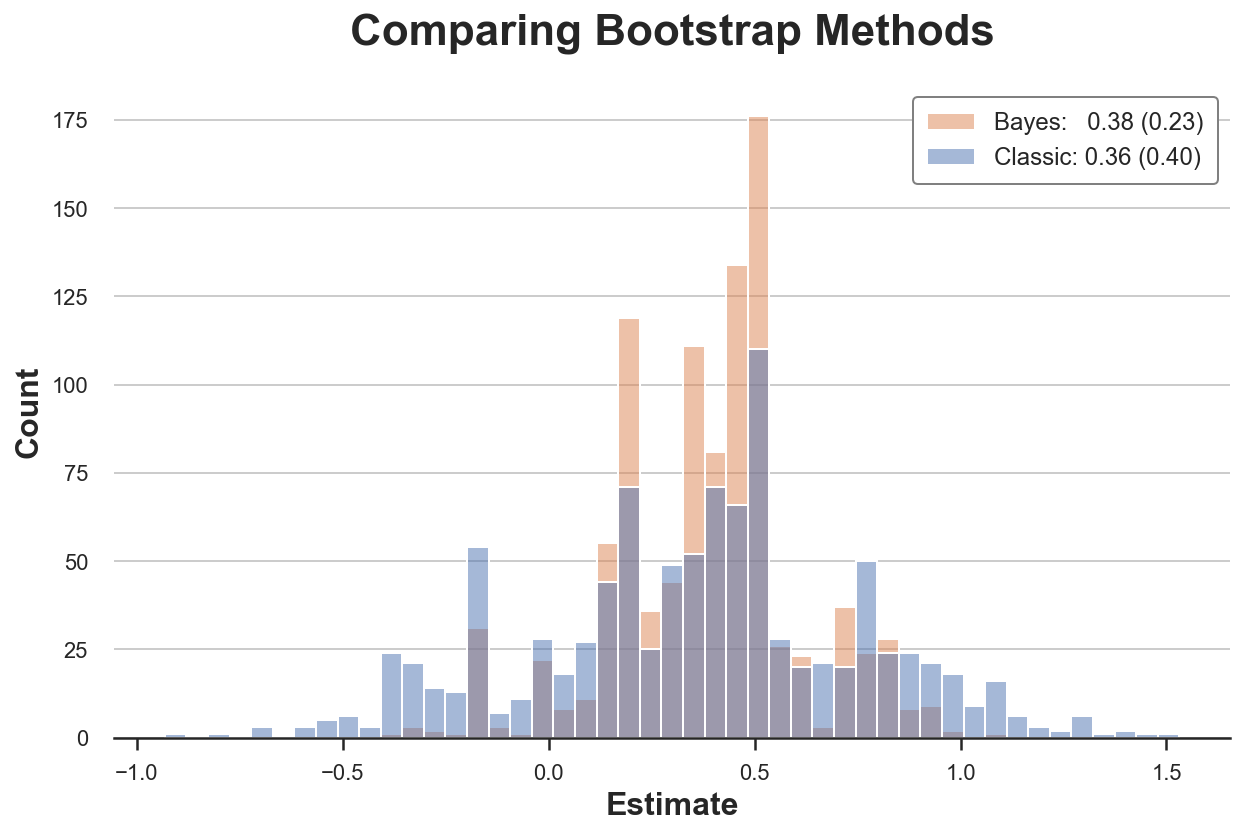

In [210]:
np.random.seed(1)
X = pd.Series(np.random.normal(0, 10, 1000))
compare_boot(X, classic_boot, twolv_boot, np.median, 1000)

In this setting, the Bayesian Bootstrap is also **more precise** than the classical bootstrap.

### Logistic Regression with Rare Outcome

Let's now explore the first of two settings in which the classical bootstrap might fall into **corner cases**. Suppose we observed a feature $x$, normally distributed, and a binary outcome $y$. We are interested in the relationship between the two variables.

In [215]:
N = 100
np.random.seed(1)
x = np.random.normal(0, 1, N)
y = np.rint(np.random.normal(x, 1, N) > 2)
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,1.624345,0.0
1,-0.611756,0.0
2,-0.528172,0.0
3,-1.072969,0.0
4,0.865408,0.0


In this case, we observe a positive outcome only in 10 observations out of 100. 

In [146]:
np.sum(df['y'])

10.0

Since the outcome is binary, we fit a [**logistic regression**](https://en.wikipedia.org/wiki/Logistic_regression) model.

In [147]:
smf.logit('y ~ d ', data=df).fit(disp=False).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-2.1518,0.334,-6.440,0.000,-2.807,-1.497
d,-23.5182,1.88e+05,-0.000,1.000,-3.68e+05,3.68e+05


Can we bootstrap the distribution of our estimator? Let's try to compute the logistic regression coefficient over 1000 bootstrap samples.

In [217]:
estimate_logit = lambda df: smf.logit('y ~ x', data=df).fit(disp=False).params[1]
for i in range(1000):
    try:
        classic_boot(df, estimate_logit, seed=i)
    except Exception as e:
        print(f'Error for bootstrap number {i}: {e}')

Error for bootstrap number 92: Perfect separation detected, results not available
Error for bootstrap number 521: Perfect separation detected, results not available
Error for bootstrap number 545: Perfect separation detected, results not available
Error for bootstrap number 721: Perfect separation detected, results not available
Error for bootstrap number 835: Perfect separation detected, results not available


For 5 samples out of 1000, we are **unable** to compute the estimate. This would not have happened with then bayesian bootstrap.

This might seem like an innocuous issue in this case: we can just drop those observations. Let's conclude with a much more dangerous example.

### Regression with few Treated Units

Suppose we observed a binary feature $x$ and a continuous outcome $y$. We are again interested in the relationship between the two variables.

In [172]:
N = 100
np.random.seed(1)
x = np.random.binomial(1, 5/N, N)
y = np.random.normal(1 + 2*x, 1, N)
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0,1.315635
1,0,-1.022201
2,0,0.693796
3,0,1.827975
4,0,1.230095


Let's compare the two bootstrap estimators of the regression coefficient of $y$ on $x$.

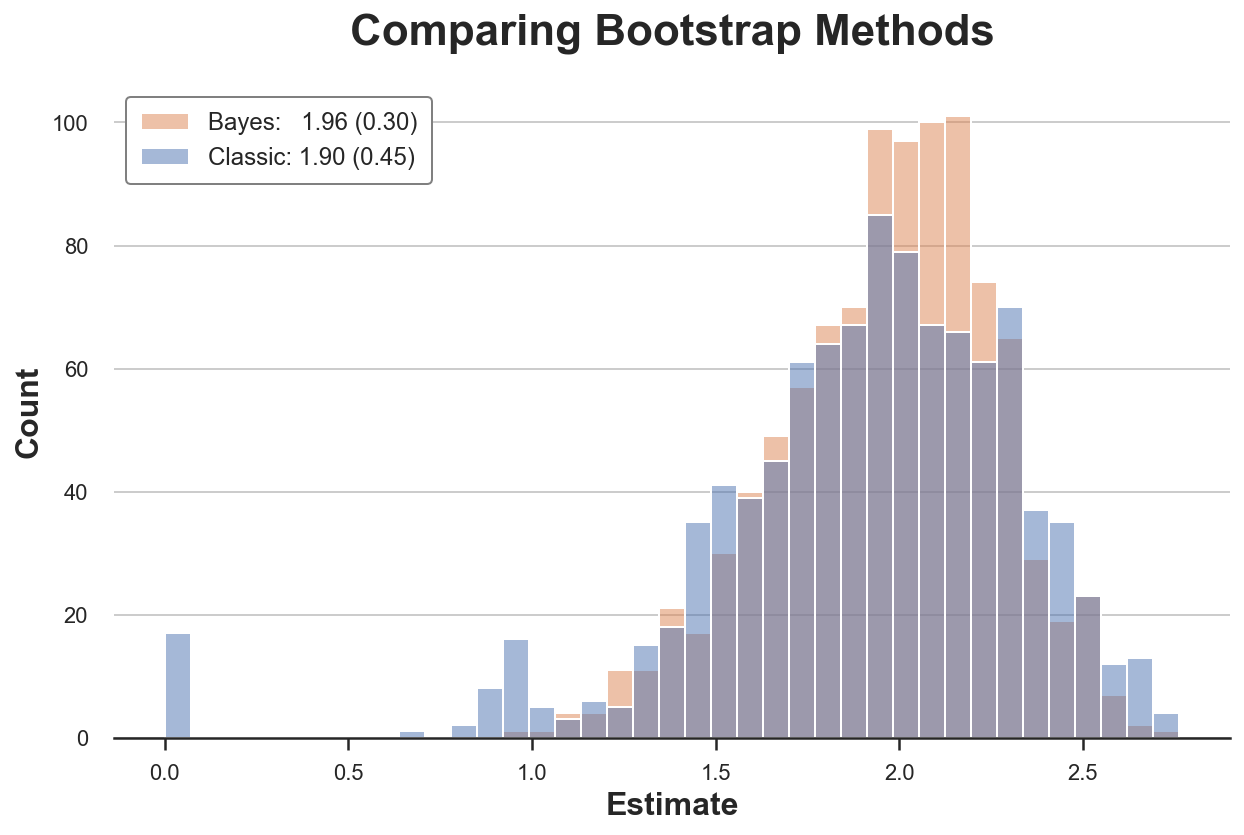

In [174]:
estimate_beta = lambda df, **kwargs: smf.wls('y ~ x', data=df, **kwargs).fit().params[1]
compare_boot(df, classic_boot, bayes_boot, estimate_beta, 1000)

The classic bootstrap procedure estimates a 50% larger variance of our estimator. Why? If we look more closely, we seen that in almost 20 re-samples, we get a very unusual estimate of zero! 

The problem is that in some samples we might not have have **any observations** with $x=1$. Therefore, in these re-samples, the estimated coefficient is zero. This does not happen with the Bayesian bootstrap, since it does not drop any observation.

The problematic part here is that we are not getting any error message or warning. This bias is very sneaky and could easily go **unnoticed**!  

## Conclusion

The article was inspired by the following tweet by Brown University professor [Peter Hull](https://sites.google.com/site/aboutpeterhull/home)

{{< tweet 1487469316010389516 >}}

Indeed, besides being a simple and intuitive procedure, the Bayesian Bootstrap is not part of the standard econometrics curriculum in economic graduate schools. 

### References

[1] B. Efron [Bootstrap Methods: Another Look at the Jackknife](https://www.jstor.org/stable/2958830) (1979), *The Annals of Statistics*.

[2] D. Rubin, [The Bayesian Bootstrap](https://www.jstor.org/stable/2240875) (1981), *The Annals of Statistics*.

[3] A. Lo, [A Large Sample Study of the Bayesian Bootstrap](https://www.jstor.org/stable/2241087) (1987), *The Annals of Statistics*.

[4] J. Shao, D. Tu, [Jacknife and Bootstrap](https://link.springer.com/book/10.1007/978-1-4612-0795-5) (1995), *Springer*.

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/bayes_boot.ipynb